# Прогнозирование оттока клиентов

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Цель проекта**

Основной нашей целью стоит это снижение убытков, связанных с неэффективными акциями по удержанию клиентов. Нам нужно построить алгоритм, который будет точно предсказывать клиентов, которые собрались уйти и предлагать акции для их удержания. Более точное определение таких клиетов поможет снизить убытки.


**План работ**

1) Проведём иследовательский анализ данных

    - Загрузим и ознакомимся с данными
    - Объеденим датасеты в один
    - Проанализируем пропуски
    - Проанализизруем числове значения
    - Выделелим целевой признак
    - Построим матрицу корреляций
    - Заполним пропуски
    
2) Подготовим датасет для обучения моделей

    - Разделим датасет на обучающую и тестовую выборку
    - Закодируем категориальные признаки
    - Стандартизируем числовые значения
    
3) Обучим 3 модели

4) Протестируем лучшую модель

    - Проанализируем лучшую модель

5) Напишем вывод

**Описание данных**

personal_new.csv - персональные данные клиента
- gender – пол
- SeniorCitizen – пенсионный статус по возрасту
- Partner – наличие супруга/супруги
- Dependents – наличие иждивенцев

contract_new.csv - информация о договоре
- BeginDate – дата начала пользования услугами
- EndDate – дата окончания пользования услугами
- Type – тип договора: ежемесячный, годовой и т.д.
- PaperlessBilling – выставления счёта по электронной почте
- PaymentMethod – способ оплаты
- MonthlyCharges – ежемесячные траты на услуги
- TotalCharges – всего потрачено денег на услуги

internet_new.csv – информация об интернет-услугах
- InternetService – наличие услуг Интернет
- OnlineSecurity – межсетевой экран
- OnlineBackup – облачное хранилище файлов для резервного копирования данных
- DeviceProtection – антивирус
- TechSupport – выделенная линия технической поддержки
- StreamingTV – онлайн-ТВ
- StreamingMovies – онлайн-кинотеатр

phone_new.csv - информация об услугах телефонии
- MultipleLines – возможность подключения телефонного аппарата к нескольким линиям одновременно

Во всех файлах столбец customerID содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Иследовательский анализ данных

### Загрузка и ознакомление с данными

In [1]:
# Импорт библиотек
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import warnings
np.warnings = warnings
warnings.filterwarnings('ignore')

%pip install missingno
import missingno as msno

%pip install phik
import phik
from phik.report import plot_correlation_matrix
from phik import report


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Импортируем датасет
try:
    contract = pd.read_csv('contract_new.csv')
    internet = pd.read_csv('internet_new.csv')
    personal = pd.read_csv('personal_new.csv')
    phone = pd.read_csv('phone_new.csv')
except:
    contract = pd.read_csv('/datasets/contract_new.csv')
    internet = pd.read_csv('/datasets/internet_new.csv')
    personal = pd.read_csv('/datasets/personal_new.csv')
    phone = pd.read_csv('/datasets/phone_new.csv')    

In [3]:
datasets = [contract, internet, personal, phone]

for i in datasets:
    display(i.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

In [4]:
# Преобразуем столбец TotalCharges в float
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

In [5]:
for i in datasets:
    display(i.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Объеденим таблицы в одну через общий столбец `customerID`

In [6]:
df = pd.merge(contract, personal, how='outer', on='customerID')
df = pd.merge(df, internet, how='outer', on='customerID')
df = pd.merge(df, phone, how='outer', on='customerID')

In [7]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [9]:
df.describe(include='object').T

,count,unique,top,freq
customerID,7043,7043,7590-VHVEG,1
BeginDate,7043,77,2014-02-01,366
EndDate,7043,67,No,5942
Type,7043,3,Month-to-month,3875
PaperlessBilling,7043,2,Yes,4171
PaymentMethod,7043,4,Electronic check,2365
gender,7043,2,Male,3555
Partner,7043,2,No,3641
Dependents,7043,2,No,4933
InternetService,5517,2,Fiber optic,3096


                                             |          | [  0%]   00:00 -> (? left)


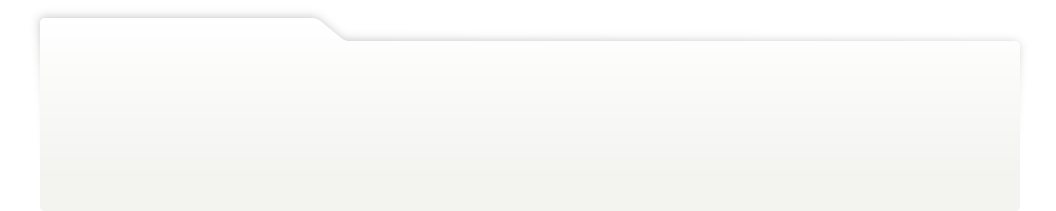
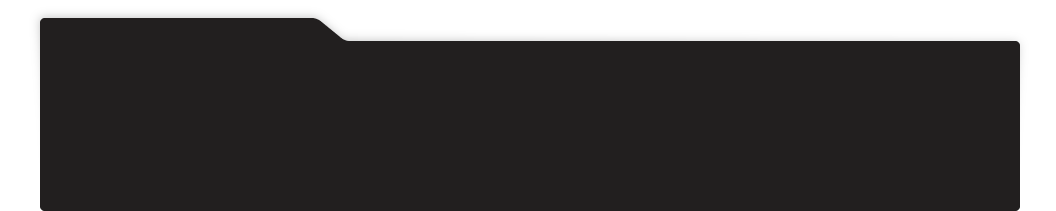
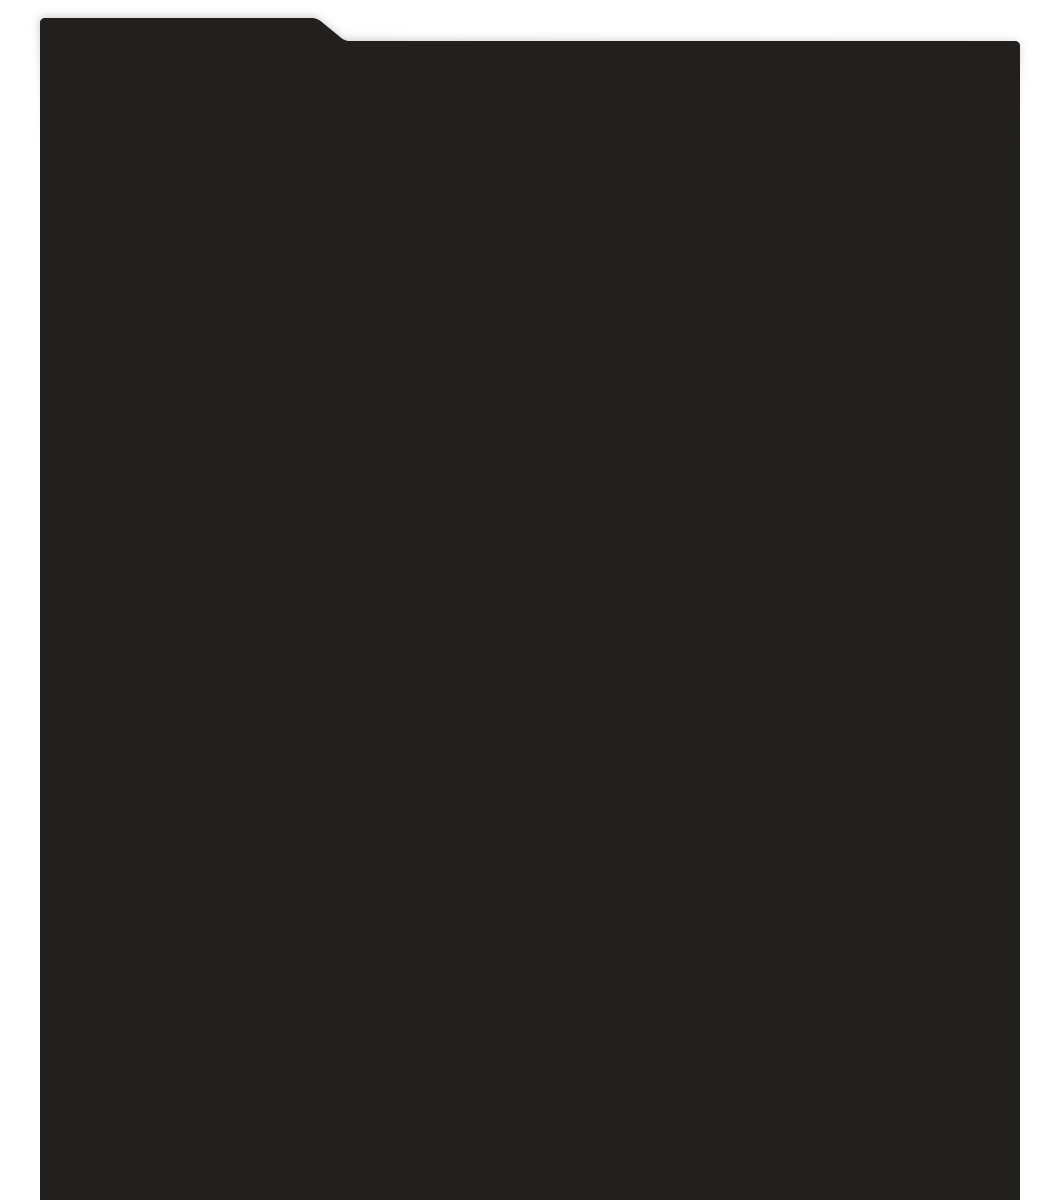
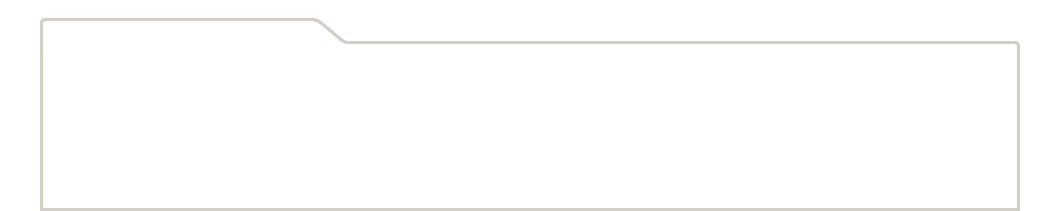
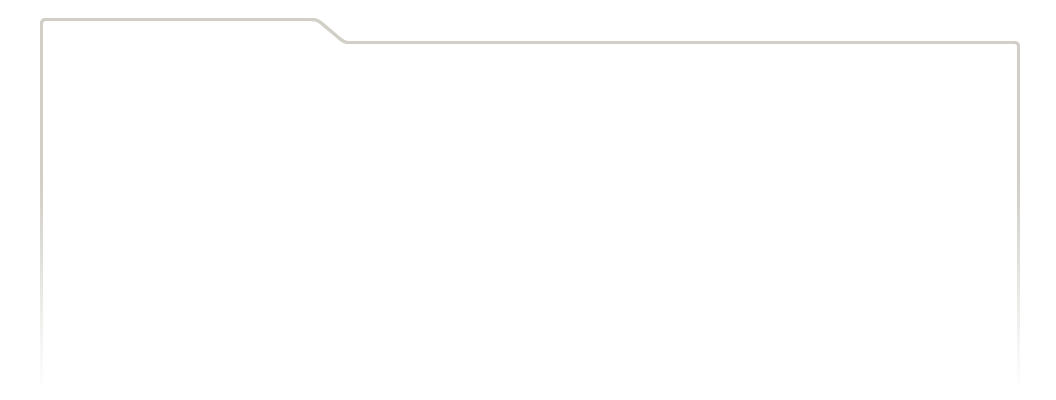
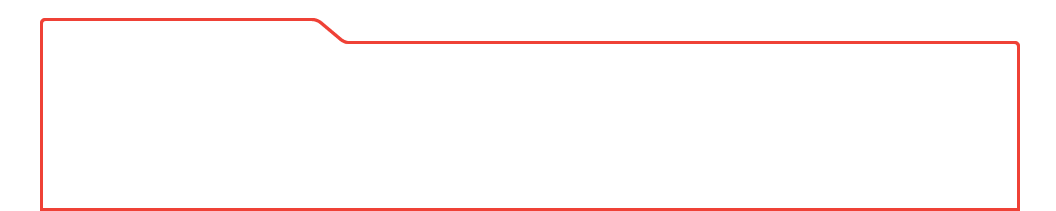
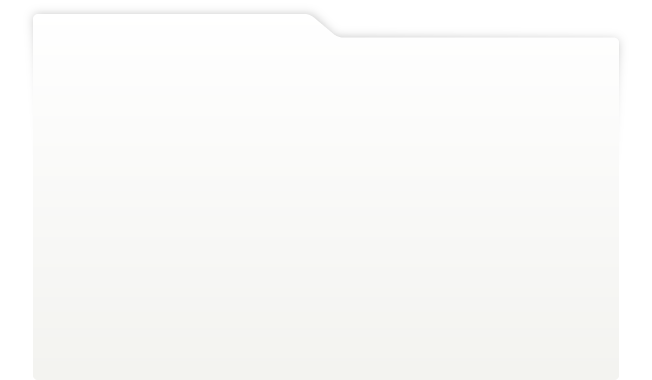
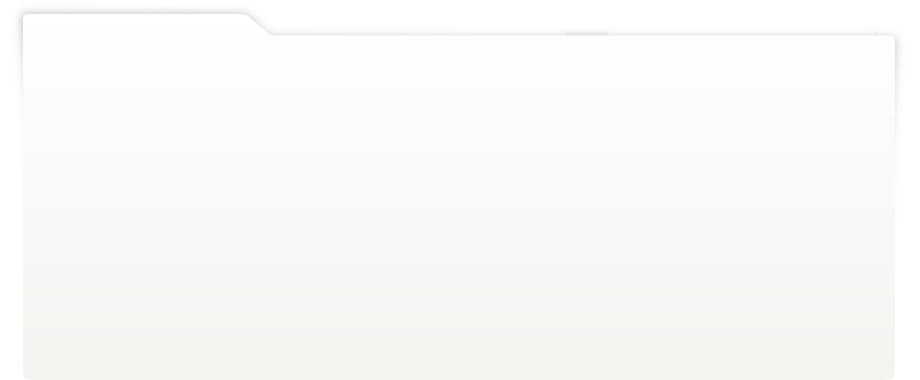
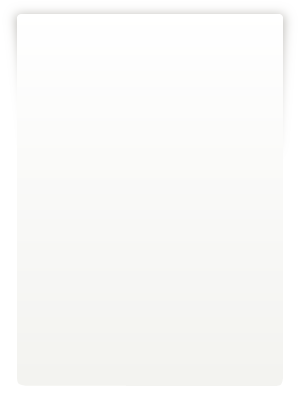
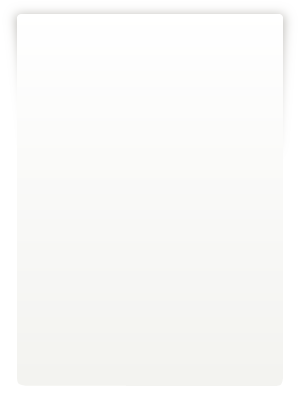
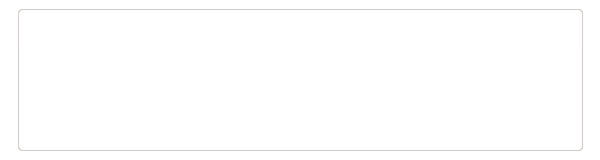
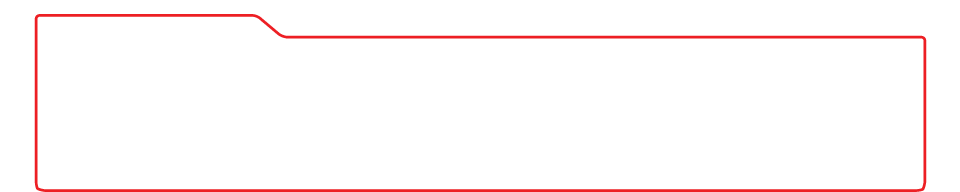
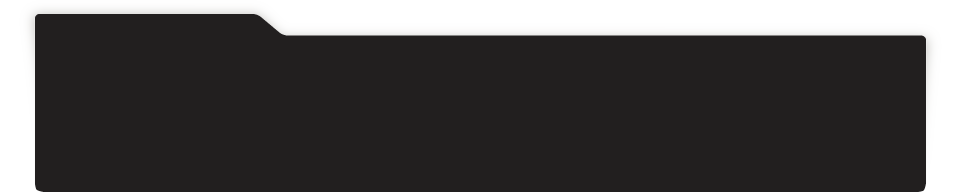
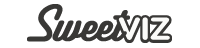
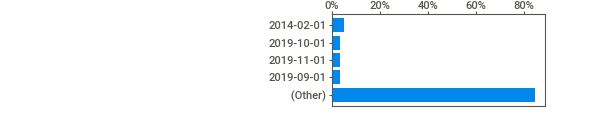
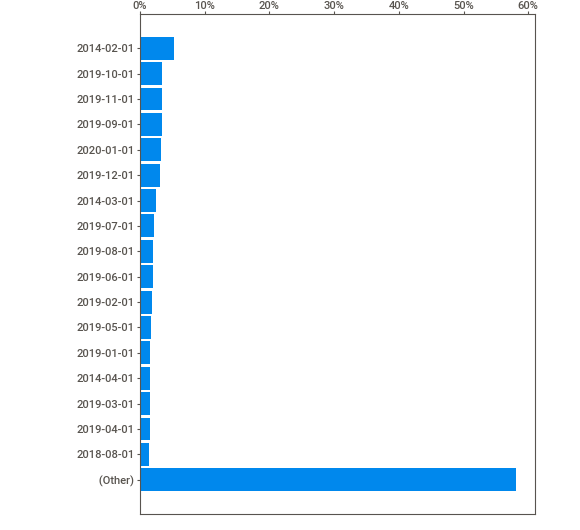
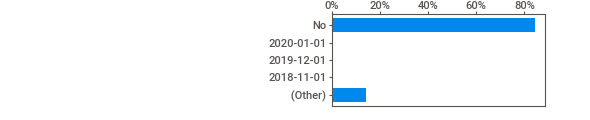
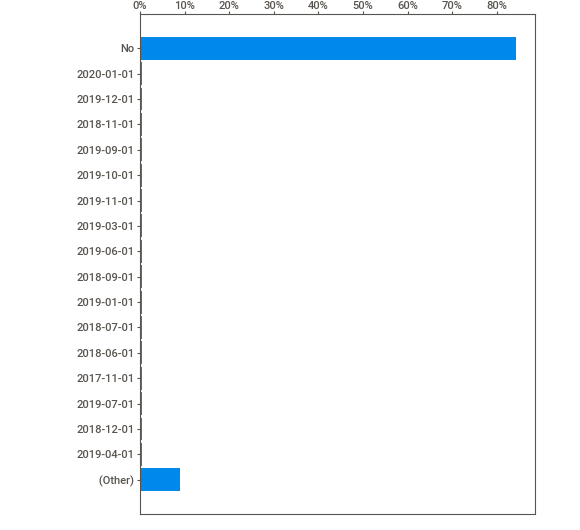
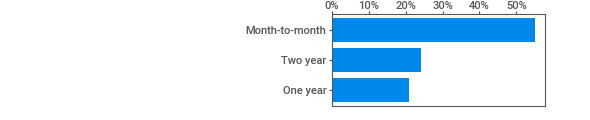
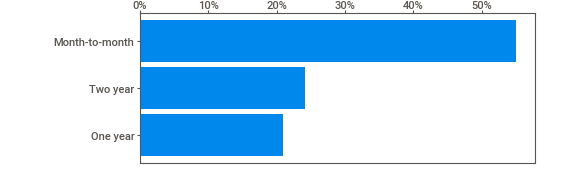
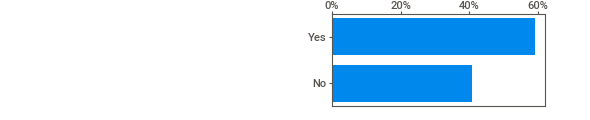
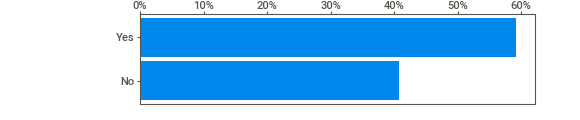
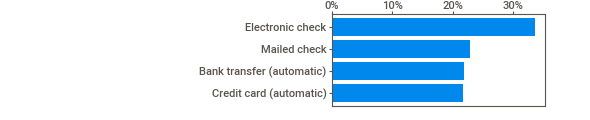
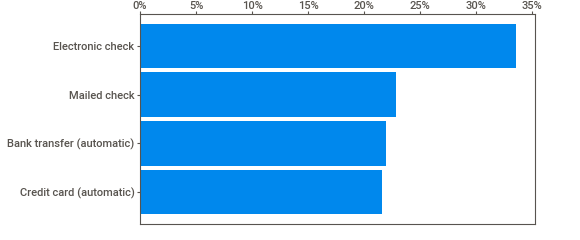
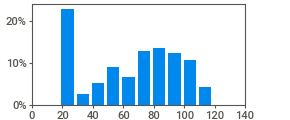
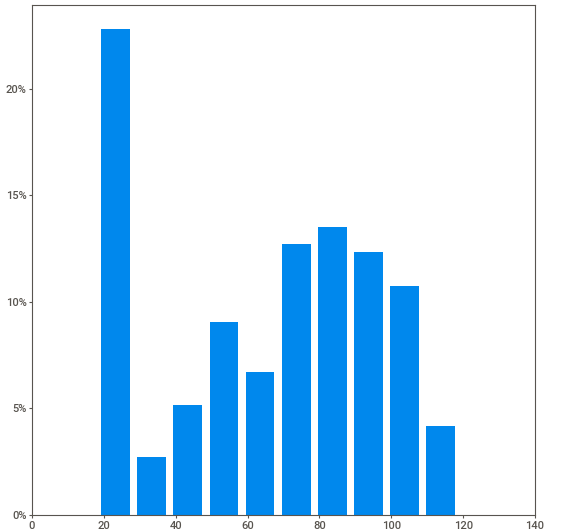
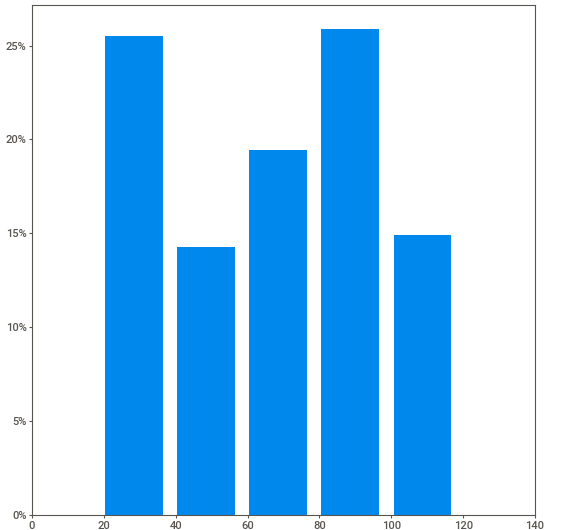
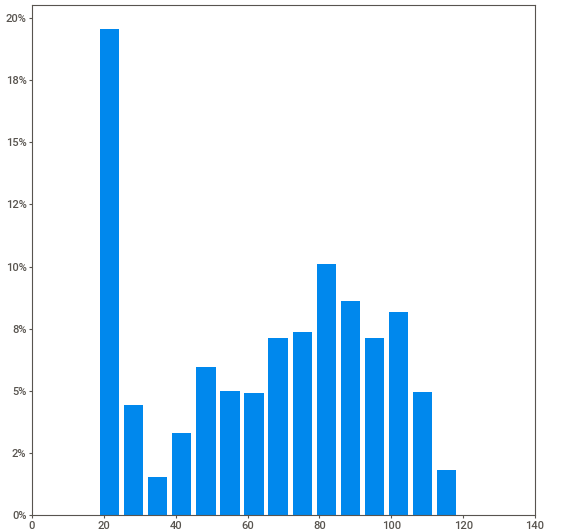
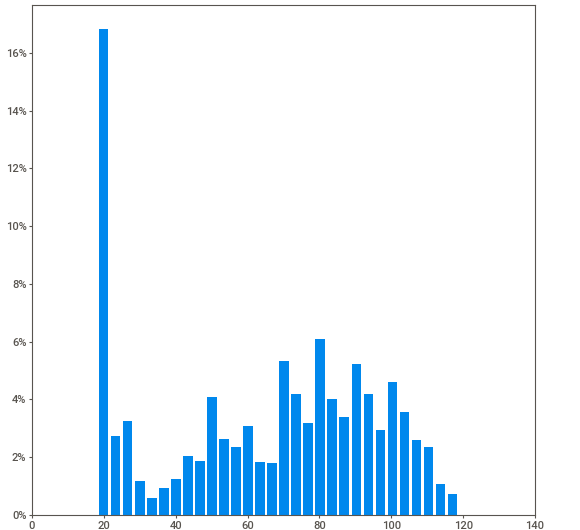
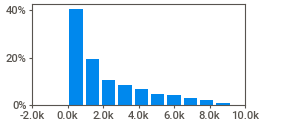
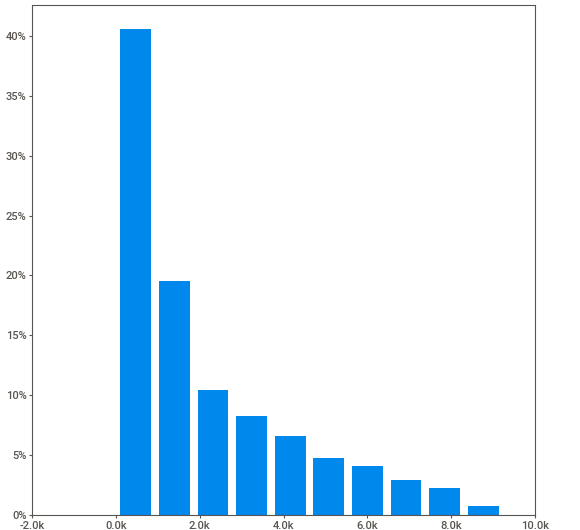
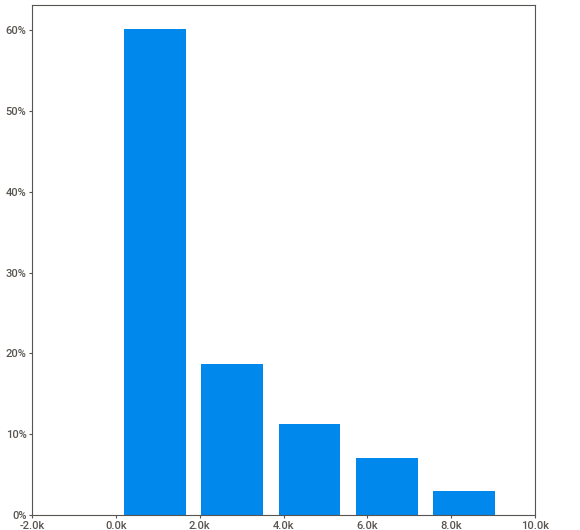
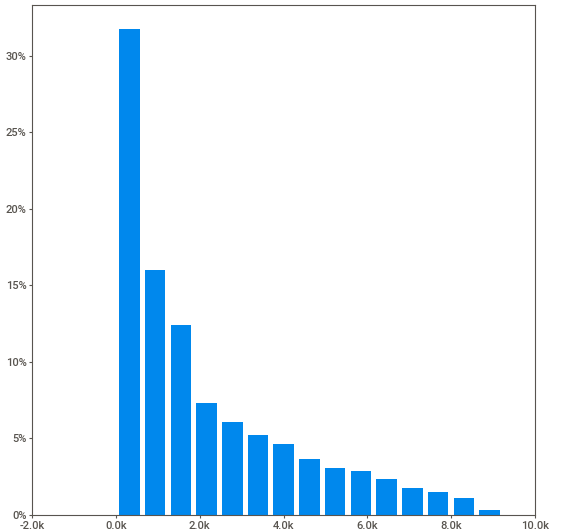
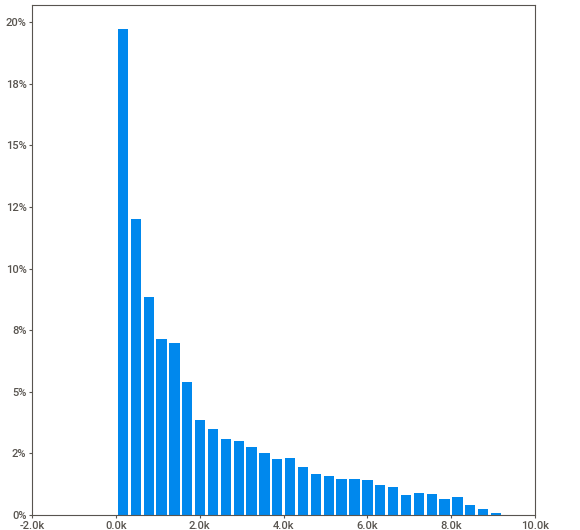
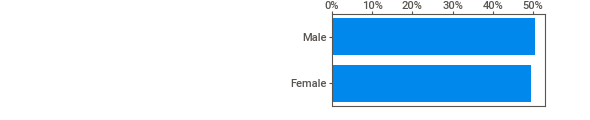
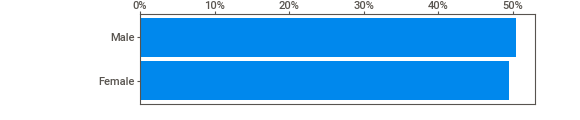
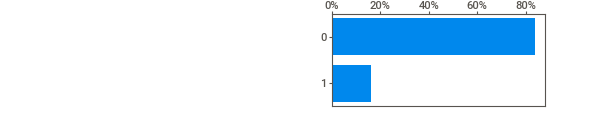
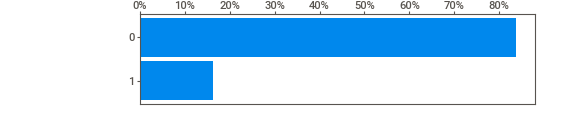
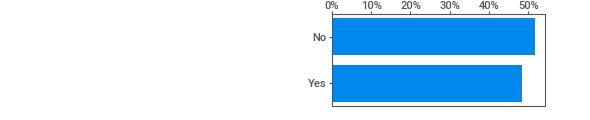
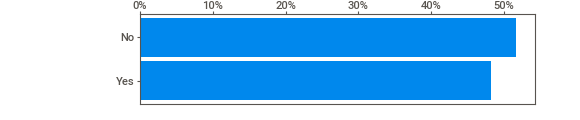
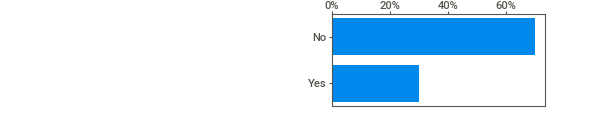
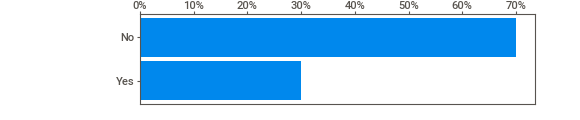
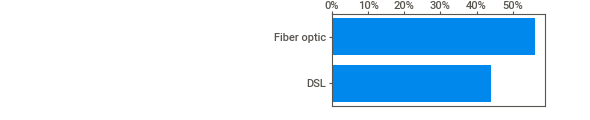
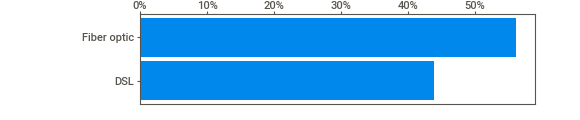
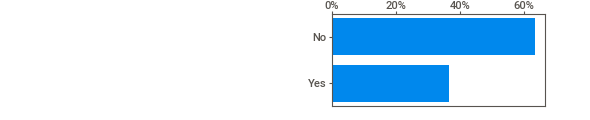
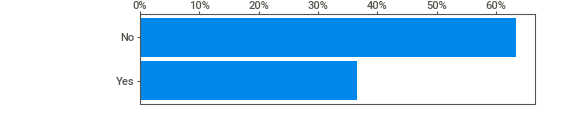
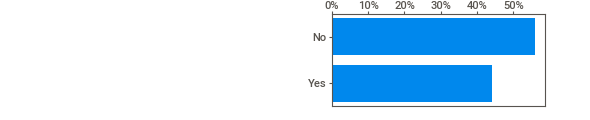
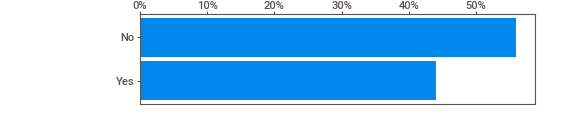
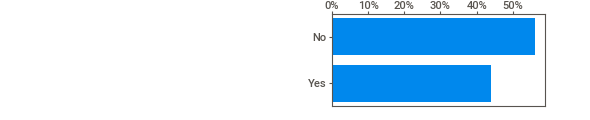
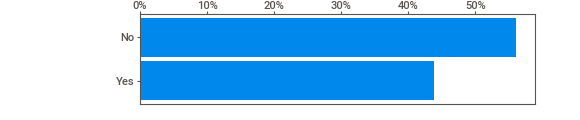
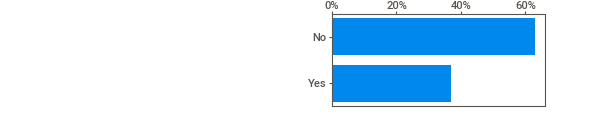
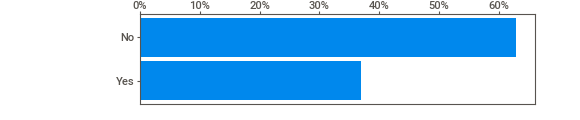
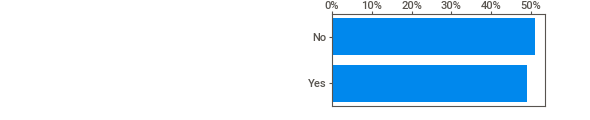
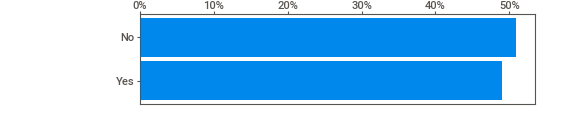
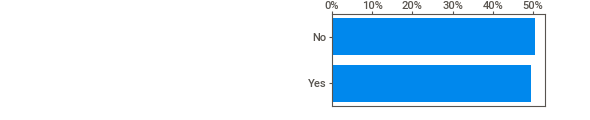
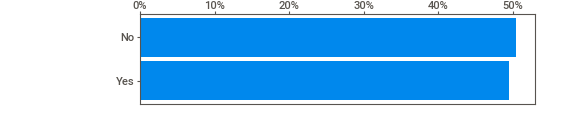
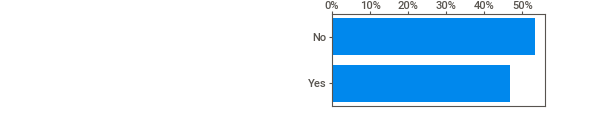
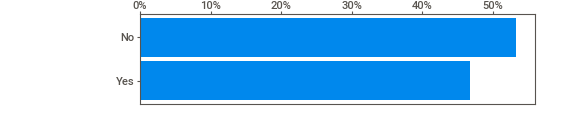
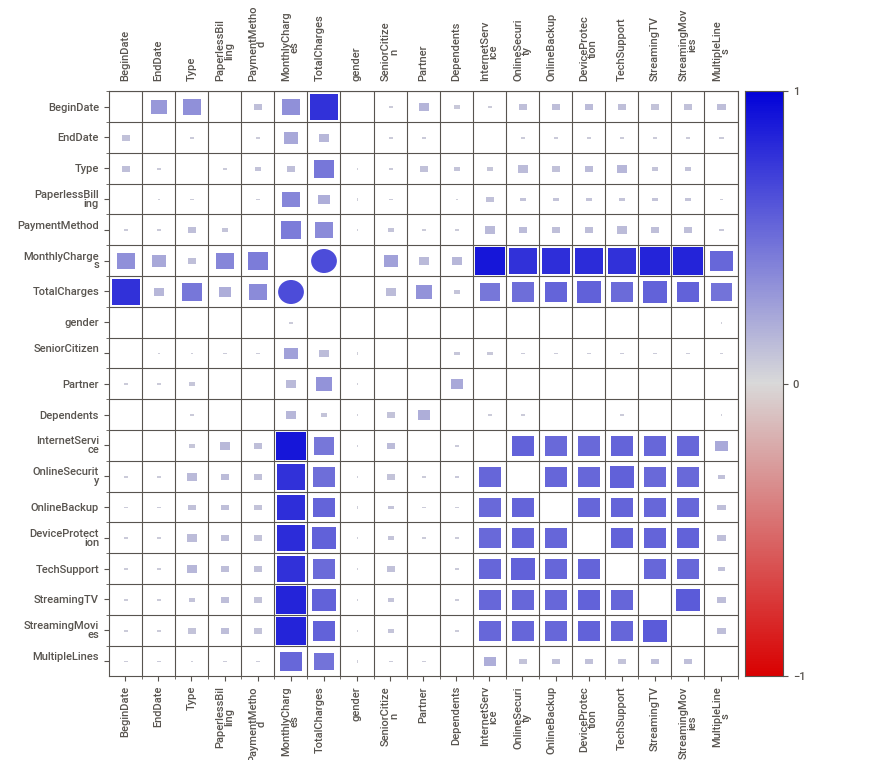
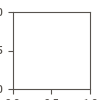

In [10]:
report = sv.analyze(df)
report.show_notebook()

### Анализ пропусков

В таблице есть пропуски. Построим матрицу пропусков, что бы посмотреть их распределение

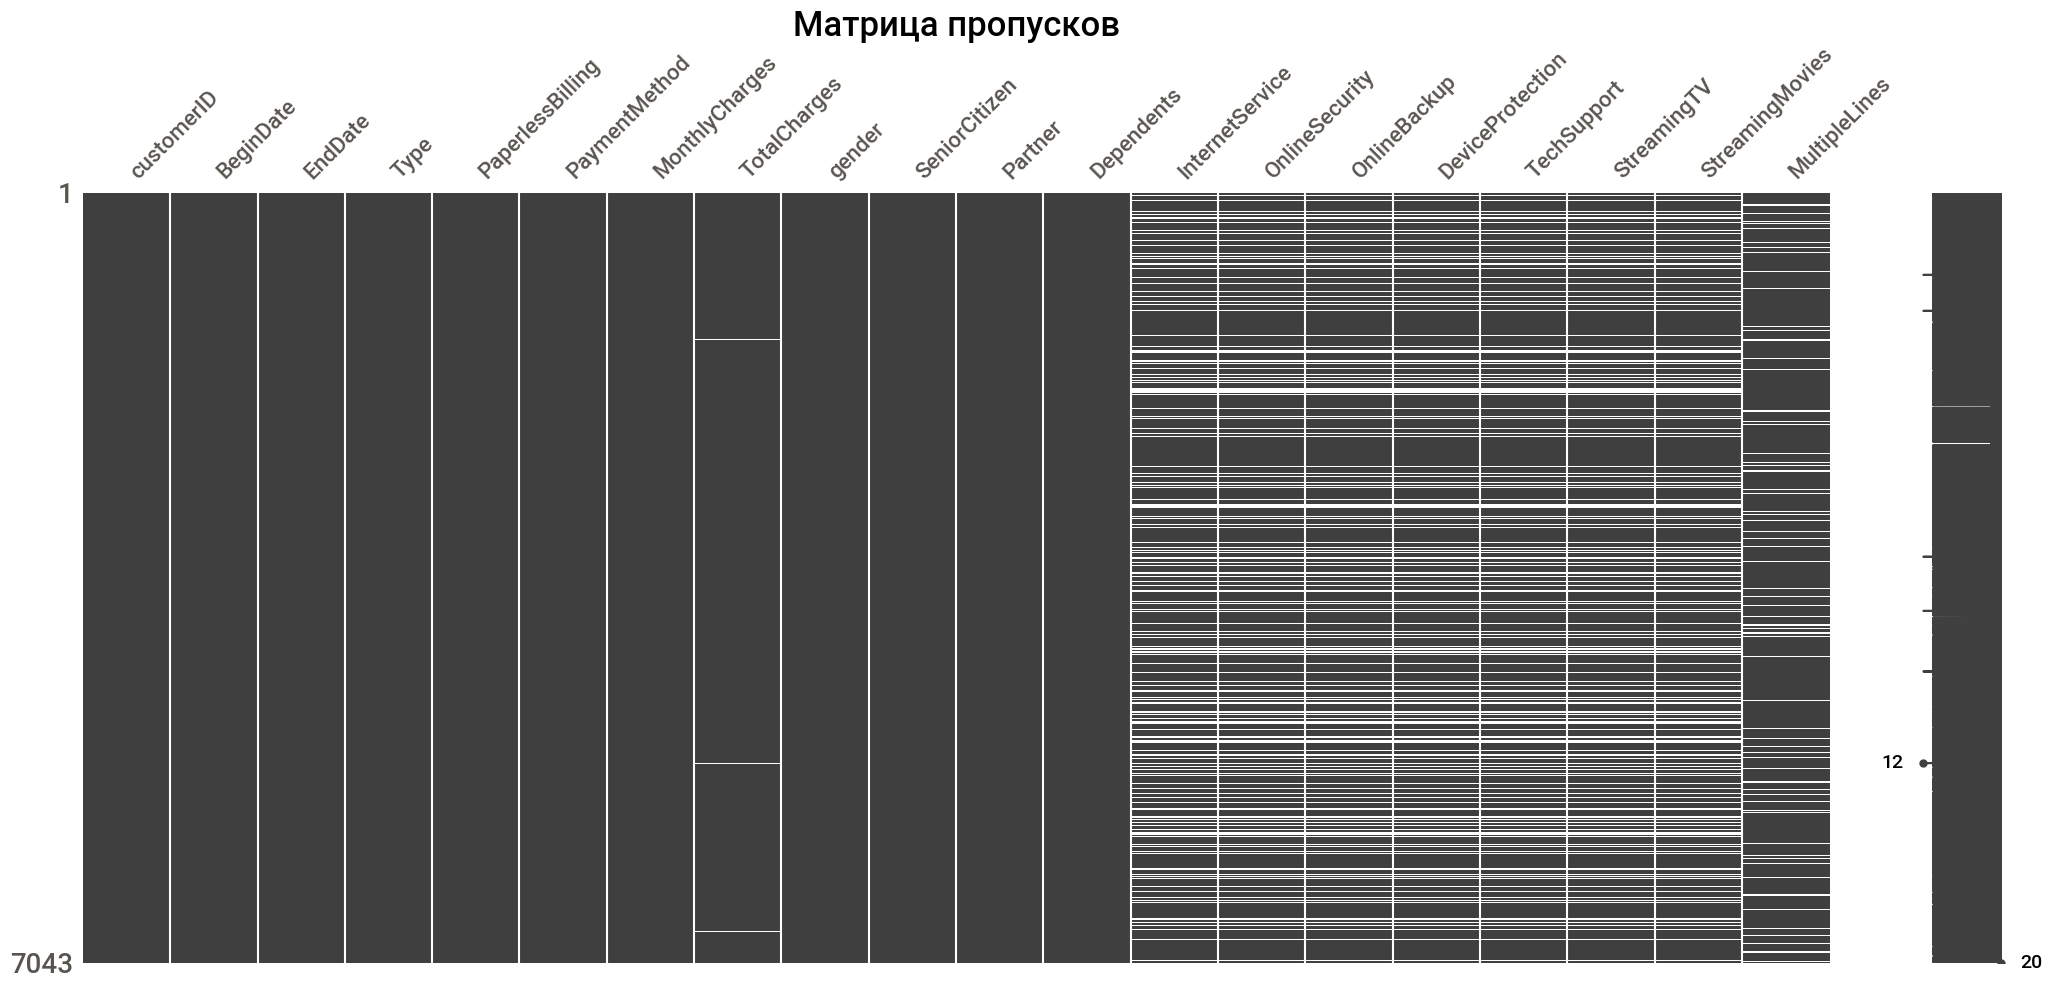

In [11]:
# Визуальное отоборажение пропусков
msno.matrix(df)
plt.title('Матрица пропусков', fontsize=25);

В столбцах с интернет услугами есть пропушки, посмотрим их ближе.

In [12]:
# Столбцы с пропусками
matrix_columns = ['InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

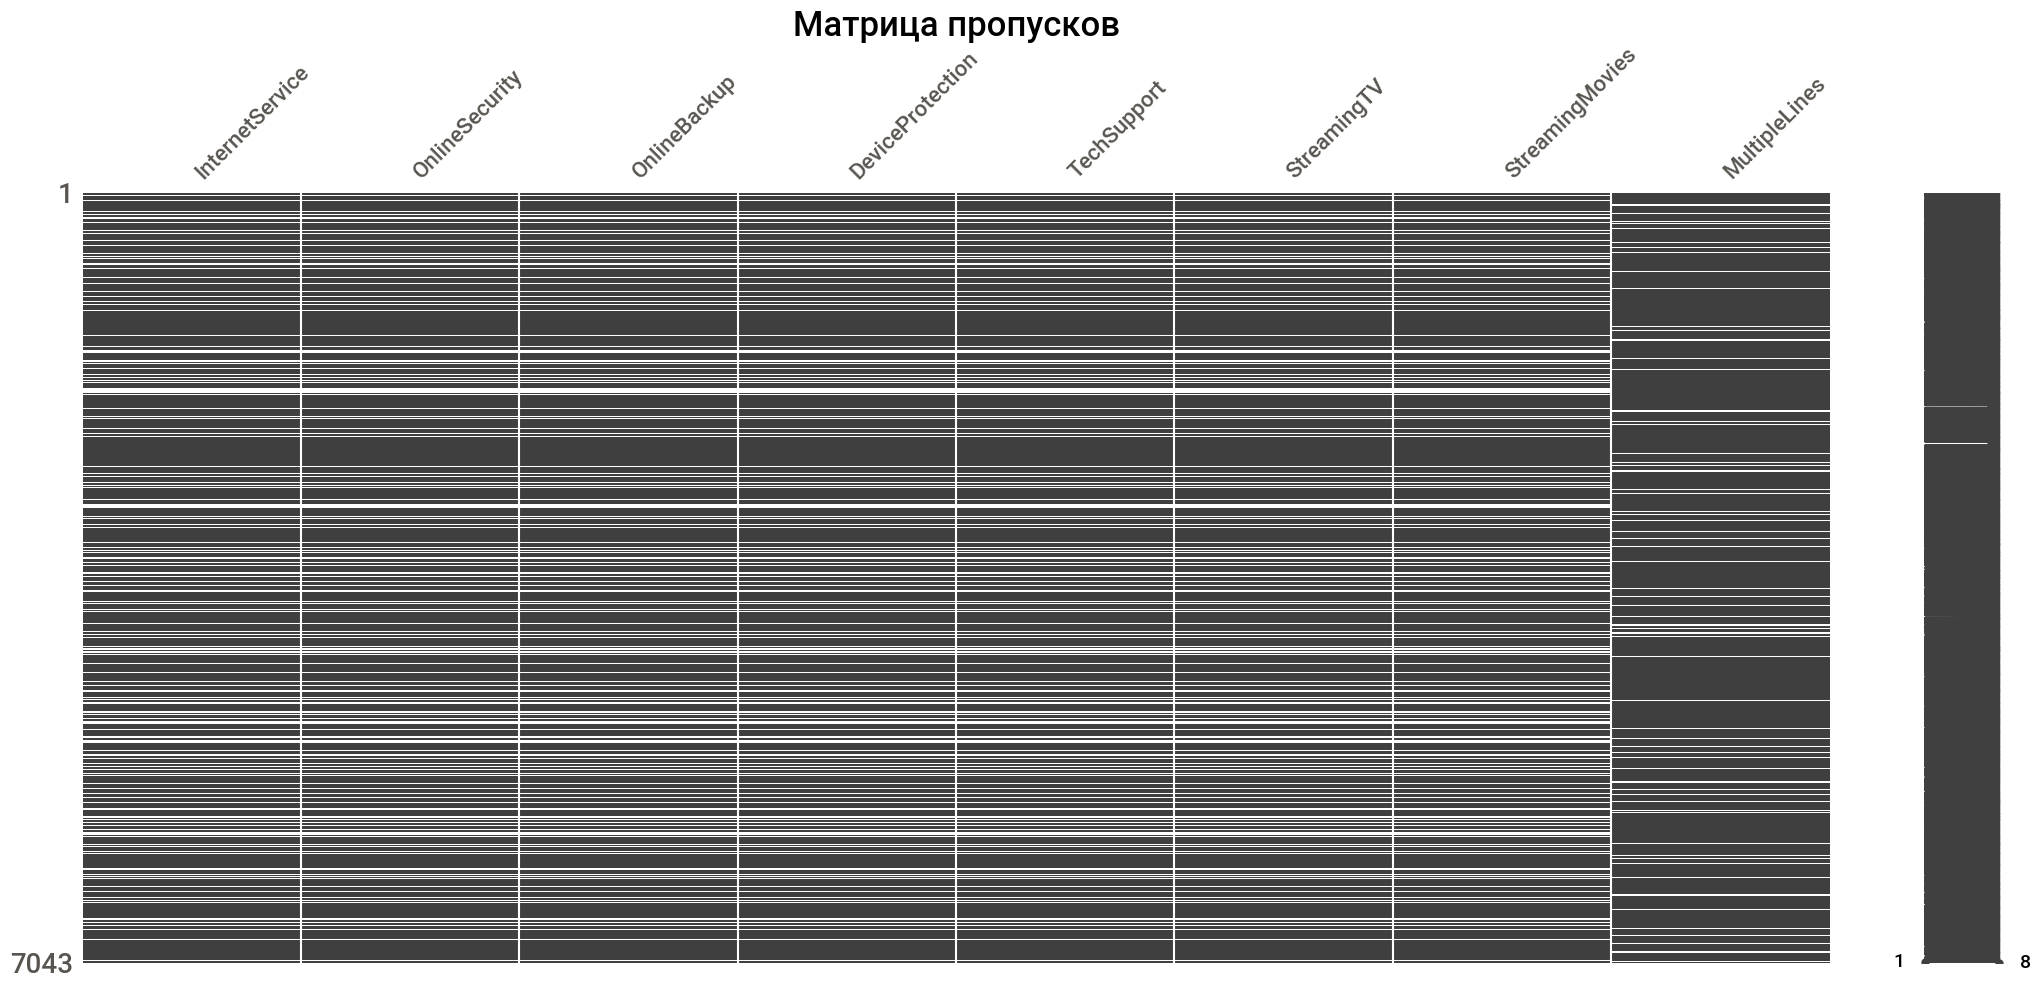

In [13]:
msno.matrix(df[matrix_columns])
plt.title('Матрица пропусков', fontsize=25);

Изначально в таблице `internet` нет пропусков. В эту таблице поподали только те клиенты, которые используют интернет услуги. Так как таких клиентов меньше, чем всех клиентов, то при соединении таблиц образовались пропуски у тех клиентов, кто не не пользуеться улслугой интернет. Значит такие пропуски можно заполнить значением `No`.

Так же есть 9 пропусков в столбце `TotalCharges`. Пропусков мало, заполним нулевыми значениями.

Пропуски в столбце `MultipleLines` заполним `No`.


### Анализ числовых значений

В данных присуствуют 2 столбца с числовыми значениями. Это `MonthlyCharges` и `TotalCharges`, ежемесячные траты на услуги
и сколько всего потрачено денег на услуги соотвественно.


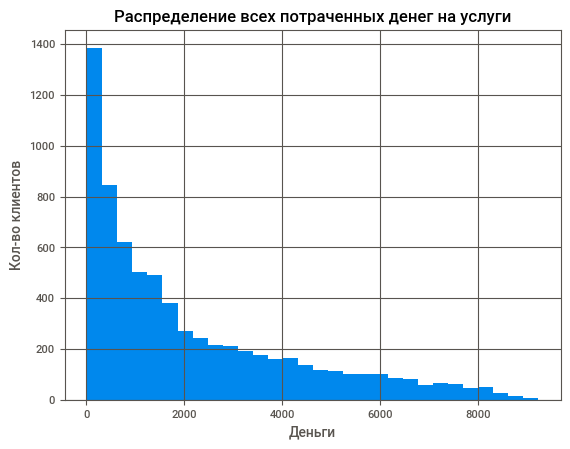

In [14]:
df['TotalCharges'].hist(bins=30)
plt.title('Распределение всех потраченных денег на услуги')
plt.xlabel('Деньги')
plt.ylabel('Кол-во клиентов');

In [15]:
df['TotalCharges'].describe()

count    7032.000000
mean     2118.621822
std      2112.736199
min        19.050000
25%       439.745000
50%      1345.275000
75%      3239.317500
max      9221.380000
Name: TotalCharges, dtype: float64

In [16]:
df['TotalCharges'].mode()

0    20.45
Name: TotalCharges, dtype: float64

В столбце `TotalCharges` медиана в 1.5 меньше, чем среднее. Данные скошены вправо. По гистограмме видно плавный длинный хвост. Возможно это самые первые клиенты, которые до сих пор пользуются услугами. С развитием бизнеса кол-во клиентов расло, однако новые клиенты ещё не потратили такое кол-во денег.

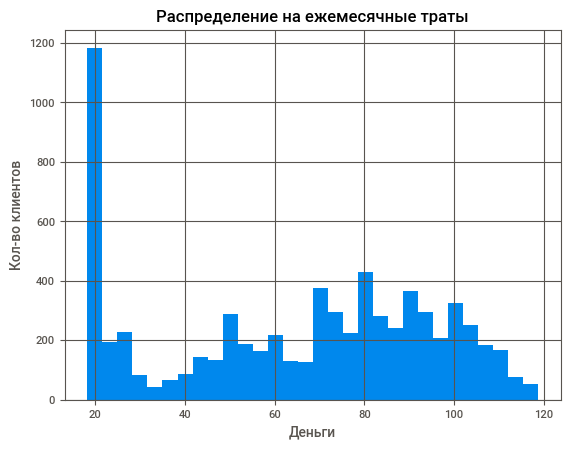

In [17]:
df['MonthlyCharges'].hist(bins=30)
plt.title('Распределение на ежемесячные траты')
plt.xlabel('Деньги')
plt.ylabel('Кол-во клиентов');

In [18]:
df['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

In [19]:
df['MonthlyCharges'].mode()

0    20.05
Name: MonthlyCharges, dtype: float64

В ежемесячных тратах на услуги (MonthlyCharges) медиана незначительно больше среднего, распредлеление скошено влево. По гистограмме и значению моды видно, что большинство клиентов платят 20 в месяц

### Создадим синтетические признаки

Создадим дополнительный признак сколько дней клиент пользовался услугами. Назовём этот признак `Tenure`.

In [20]:
# Создадим новый столбец и переведём все 'No' в последнюю актуальную дату 2020-01-01
df['EndDate_new'] = df['EndDate'].map(lambda x: '2020-01-01' if x == 'No' else x)

In [21]:
# Приведём столбцы с датой к типу datetime
df['BeginDate'] = pd.to_datetime(df['BeginDate'])
df['EndDate_new'] = pd.to_datetime(df['EndDate_new'])

In [22]:
# Создадим новый признак 'Tenure'. Вычислим разность между конечной датой и начальной и вычленим дни
df['Tenure'] = (df['EndDate_new'] - df['BeginDate']).dt.days

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

### Выделение целевого признака

Выделим целевой признак из столбца `EndDate`. Сейчас в нём такие значения как `No` - клиент не ушёл, а остальные значения это даты ухода клиентов. Даты уходов клиентов следует перевести в значение `Yes` - клиент ушёл. Так у нас получиться бинарная классификация.

In [24]:
# Преобразуем даты в Yes и No
df['EndDate'] = df['EndDate'].map(lambda x: 'Yes' if x != 'No' else x)

In [25]:
# Выведем уникальные значения после преобразования
df['EndDate'].unique()

array(['No', 'Yes'], dtype=object)

In [26]:
# Переминуем столбец в Target
df.rename(columns={'EndDate': 'Target'}, inplace=True)

Построим график, что бы посмотреть распределение классов.

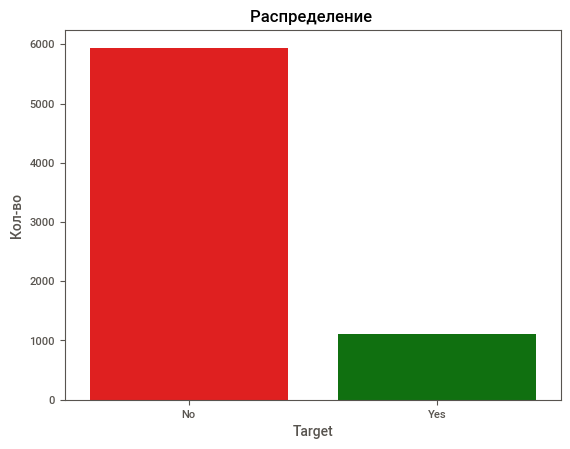

In [27]:
sns.countplot(data=df, x='Target', palette=['red', 'green'])
plt.title('Распределение ')
plt.ylabel('Кол-во');

В целевом признаке присуствует дизбаланс классов. При обучении алгоритма машинного обучения это следует учесть.

### Проверим корреляции

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Tenure']


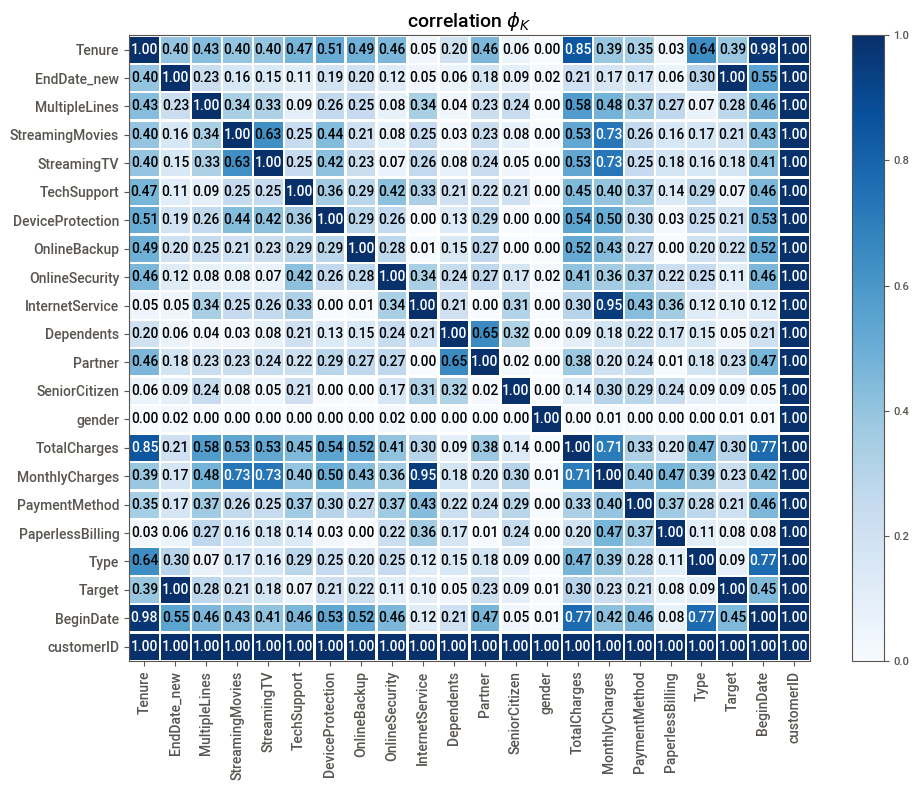

In [28]:
phik_overview = (df.phik_matrix()).round(2)
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map='Blues',
                        title=r"correlation $\phi_K$",
                        figsize=(10, 8))
plt.tight_layout()

По матрице корреляций можно заметить такое вещи:
- Пол (gender) не с чем не коррелирует. Этот столбец можно будет удалить.

### Заполним пропуски

В столбцах с интернет услугами пропуски. Заполним их значением `No`, так как это значит, что клиент не использовал данную услугу

In [29]:
for i in matrix_columns:
    df[i].fillna(value='No', inplace=True)

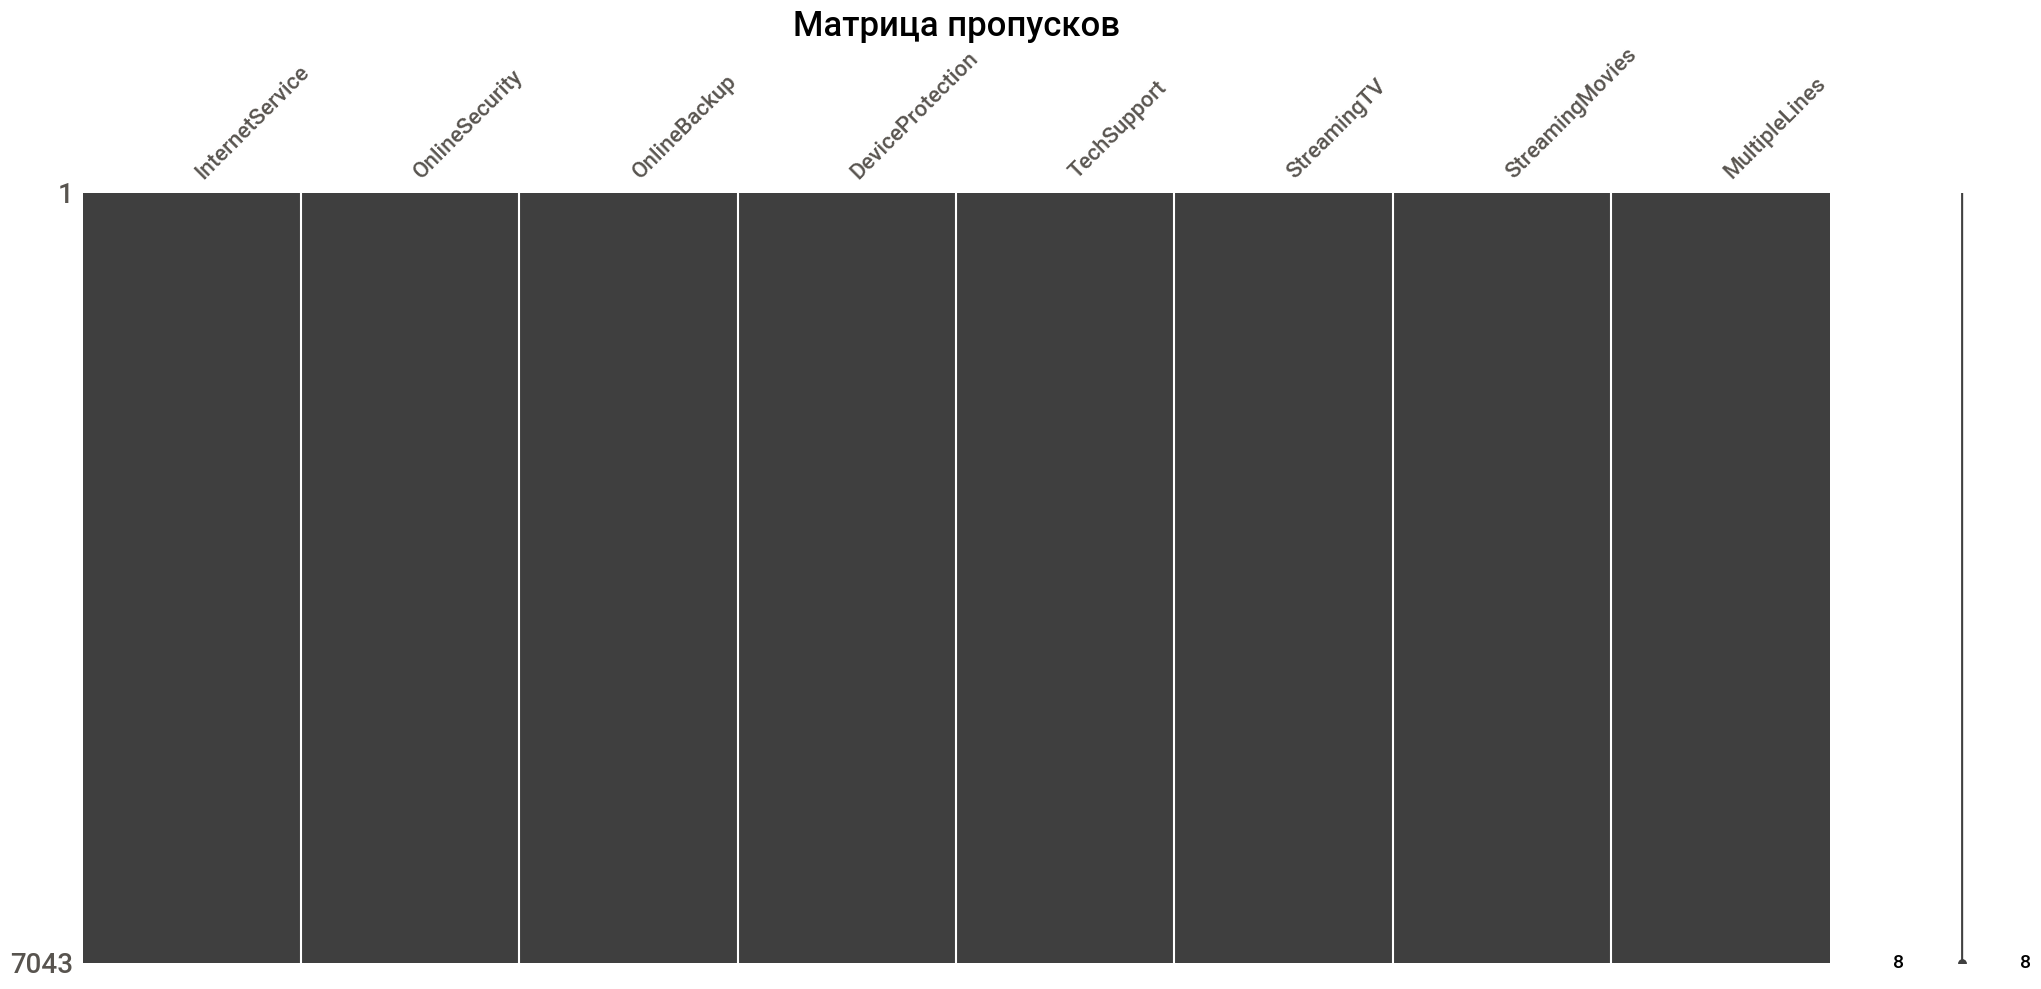

In [30]:
msno.matrix(df[matrix_columns])
plt.title('Матрица пропусков', fontsize=25);

Уберём пропуски из столбца `TotalCharges`. Заполним нулевыми значениями.

In [31]:
df['TotalCharges'].fillna(0, inplace=True)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   Target            7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

## Поготовка датасета для обучения моделей

Наша задача это бинарная классификация. Для этой задачи мы выбрали 3 модели:

1) Логистическая регрессия
2) Случайный лес
3) Градиентный бустинг

Перед обучением моделей нам нужно подготовить датасет.

Сделаем это в 3 шага:

1) Уберём лишнии признаки из датасета

2) Разделим датасет на обучающую и тестовую выборку. Затем выделим признаки и целевой признак

3) Создадим конвейер (pipeline) для предобаботки

In [33]:
# Список столбцов для удаления из датасета
del_list = ['gender', 'BeginDate', 'customerID', 'EndDate_new']

# Удалим ненужные признаки из датасета
df.drop(columns=del_list, inplace=True)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Target            7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   float64
 6   SeniorCitizen     7043 non-null   int64  
 7   Partner           7043 non-null   object 
 8   Dependents        7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  MultipleLines     7043 non-null   object 


In [35]:
# Сделаем копию нашего датасета
df_ml = df.copy()

In [36]:
# Сохраним значение random_state в отдельную переменную
state = 310723

### Подготовка датасета для модели логистической регресии и случайного леса

Разделим датасет на обучающую и тестовую выборку в соотношении 3 к 1

In [37]:
# Раздлелим датасет на обучающую и тестовую выборку
train, test = train_test_split(df_ml, test_size=0.25, random_state=state)

In [38]:
print('Размер обучающей выборки:', train.shape)
print('Размер тестовой выборки:', test.shape)

Размер обучающей выборки: (5282, 18)
Размер тестовой выборки: (1761, 18)


Выделим признаки и целевой признак

In [39]:
# Обучающая выборка
train_features = train.drop(['Target'], axis=1)
train_target = train['Target']

# Тестовая выборка
test_features = test.drop(['Target'], axis=1)
test_target = test['Target']

### Подготовка датасета для модели градиентного бустинга

В этом проекте будем применять модель градиентого бустинга в реализации Catboost. Для Catboost категориальные признаки не нужно кодировать и не нужно стандартизировать числовые признаки. Нужно только привести категориальные признаки к типу `category`

In [40]:
# Столбцы с категориальными признаками
cat_columns = ['Type', 'PaperlessBilling', 'PaymentMethod', 'Partner', 
               'Dependents','InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
               'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

# Преобразование выбранных столбцов в тип 'category'
df_ml[cat_columns] = df_ml[cat_columns].astype('category')

In [41]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Target            7043 non-null   object  
 1   Type              7043 non-null   category
 2   PaperlessBilling  7043 non-null   category
 3   PaymentMethod     7043 non-null   category
 4   MonthlyCharges    7043 non-null   float64 
 5   TotalCharges      7043 non-null   float64 
 6   SeniorCitizen     7043 non-null   int64   
 7   Partner           7043 non-null   category
 8   Dependents        7043 non-null   category
 9   InternetService   7043 non-null   category
 10  OnlineSecurity    7043 non-null   category
 11  OnlineBackup      7043 non-null   category
 12  DeviceProtection  7043 non-null   category
 13  TechSupport       7043 non-null   category
 14  StreamingTV       7043 non-null   category
 15  StreamingMovies   7043 non-null   category
 16  MultipleLines     7043 n

In [42]:
# Раздлелим датасет на обучающую и тестовую выборку
train, test = train_test_split(df_ml, test_size=0.25, random_state=state)

In [43]:
print('Размер обучающей выборки:', train.shape)
print('Размер тестовой выборки:', test.shape)

Размер обучающей выборки: (5282, 18)
Размер тестовой выборки: (1761, 18)


In [44]:
# Обучающая выборка
train_features_boost = train.drop(['Target'], axis=1)
train_target_boost = train['Target']

# Тестовая выборка
test_features_boost = test.drop(['Target'], axis=1)
test_target_boost = test['Target']

### Создаём Pipeline

Создадим конвейер (pipeline) для наших моделей.

В него будет входить 2 вещи:
1) Предобработка данных
    - Кодирование категориальных признаков
    - Стандартизация числовых признаков
2) Подбор гиперпараметров через поиск по сетке (GridSearchCV) через максимизацию метрики Roc-Auc.

В целевом признаке есть дисбаланс классов. Что бы их сбалансировать будем исползовать параметр `class_weigth='balanced'`.

In [45]:
# Определяем список числовых и категориальных признаков
numeric_features = ['MonthlyCharges', 'TotalCharges', 'Tenure']
categorical_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Partner', 
                       'Dependents','InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

In [46]:
# Список столбцов с категориальными признаками для модели градиентого бустинга Catboost
cat_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'Partner', 
               'Dependents','InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
               'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

In [47]:
# Cоздаём конвейер для предобработки данных
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_features),
    ('num', StandardScaler(), numeric_features)
])

In [48]:
# Cоздаём конвейер для предобработки данных
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_features),
    ('num', StandardScaler(), numeric_features)
])

# Создаём конвейер с логистической регрессией
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=state, class_weight='balanced'))
])

# Создаём конвейер со случайным лесом
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=state, class_weight='balanced'))
])

# Создаём конвейер для градиентого бустинга CatBoost
pipeline_cb = Pipeline([
    ('classifier', CatBoostClassifier(random_state=state, auto_class_weights='Balanced', cat_features=cat_features, verbose=0))
])

In [49]:
# Задаем сетку параметров для логистической регресии
param_lr = {}

# Задаём сетку параметров для случайного леса
param_rf = {
    'classifier__max_depth': [5, 10, 15],
    'classifier__n_estimators': [100, 200, 300]
}

#Задаём сетку параметров для градиентного бустинга
param_cb = {
    'classifier__learning_rate': [0.01, 0.001],
    'classifier__depth': [5, 6],
    'classifier__iterations': [1500, 2000]
}

In [50]:
# Создаем объект GridSearchCV для Логистической регрессии
LR = GridSearchCV(pipeline_lr, param_lr, cv=5, scoring='roc_auc')

# Создаём объект GridSearchCV для случайного леса
RF = GridSearchCV(pipeline_rf, param_rf, cv=5, scoring='roc_auc')

# Создаём объект GridSearchCV для градиентного бустинга
CB = GridSearchCV(pipeline_cb, param_cb, cv=5, scoring='roc_auc')

## Обучение моделей

Обучим 3 модели:

- Логистическую регрессию
- Случайный лес
- Градиентный бустинг в реализации CatBoost

In [51]:
# Запускаем обучение логистической регрессии
LR.fit(train_features, train_target);

In [52]:
# Выводим лучшие параметры и результаты
print('Логистическая регрессия')
print("Лучшие параметры:", LR.best_params_)
print("Лучший результат:", LR.best_score_)

Логистическая регрессия
Лучшие параметры: {}
Лучший результат: 0.7709092678227977


In [53]:
# Запускаем обучение случайного леса
RF.fit(train_features, train_target);

In [54]:
# Выводим лучшие параметры и результаты
print('Случайный лес')
print("Лучшие параметры:", RF.best_params_)
print("Лучший результат:", RF.best_score_)

Случайный лес
Лучшие параметры: {'classifier__max_depth': 10, 'classifier__n_estimators': 300}
Лучший результат: 0.8103788546027075


In [55]:
%%time
# Запускаем обучени для градиентного бустинга
CB.fit(train_features_boost, train_target_boost);

CPU times: total: 1h 23min 31s
Wall time: 39min 9s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        <catboost.core.CatBoostClassifier object at 0x0000026D429701C0>)]),
             param_grid={'classifier__depth': [5, 6],
                         'classifier__iterations': [1500, 2000],
                         'classifier__learning_rate': [0.01, 0.001]},
             scoring='roc_auc')

In [56]:
# Выводим лучшие параметры и результаты
print('Градиентный бустинг')
print("Лучшие параметры:", CB.best_params_)
print("Лучший результат:", CB.best_score_)

Градиентный бустинг
Лучшие параметры: {'classifier__depth': 6, 'classifier__iterations': 2000, 'classifier__learning_rate': 0.01}
Лучший результат: 0.8523943501082604


Наибольшее значение метрики ROC-AUC получила модель градиентного бустинга CatBoost. Протестируем эту модель на тестовой выборке.

## Тестирование лучшей модели

Протестируем модель градиентного бустинга CatBoost, так как она достигла лучшей метрики ROC-AUC и превысила минимальный порог в 0.85.

Так же проведём анализ результатов. Построим ROC-кривую и матрицу ошибок, а так же выведем список важности признаков модели.

In [57]:
# Сохраним лучшую модель в best_model
best_model = CB.best_estimator_

In [58]:
# Делаем предсказания на тестовых данных с помощью лучшей модели
prediction = best_model.predict(test_features_boost)

In [59]:
# Получаем вероятности принадлежности к классу 1
prediction_proba = best_model.predict_proba(test_features_boost)[:, 1]

In [60]:
# Вычисляем ROC AUC
roc_auc = roc_auc_score(test_target_boost, prediction_proba)

In [61]:
# Вычисляем accuracy
accuracy = accuracy_score(test_target_boost, prediction)

In [62]:
# Вычисляем матрицу ошибок
conf_matrix = confusion_matrix(test_target_boost, prediction)

In [63]:
# Заменяем 'No' на 0 и 'Yes' на 1
test_target_boost = test_target_boost.replace({'No': 0, 'Yes': 1})

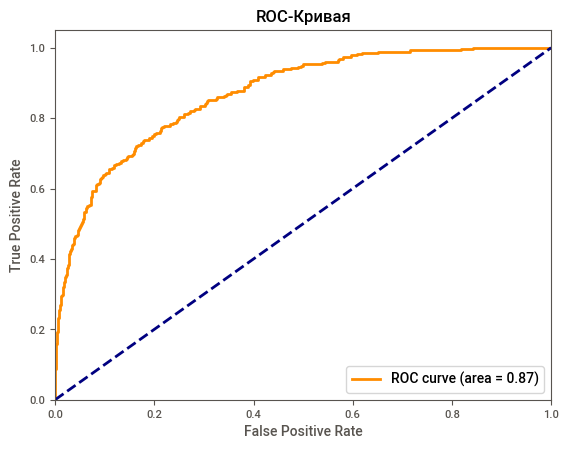

In [64]:
# Рисуем ROC кривую
fpr, tpr, _ = roc_curve(test_target_boost, prediction_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Кривая')
plt.legend(loc="lower right")
plt.show()

Значение ROC-AUC показывает качество модели бинарной классификации и оценивает ее способность различать между классами. Значение этой метрики находится в диапазоне от 0 до 1. Чем ближе к 1, тем лучше модель разделяет классы. Значение 0.5 указывает на случайный характер.

Наша модель показывает значение ROC-AUC > 0.85. Это являеться хорошим результатом, который указывает на то, что наша модель имеет высокую способность различать между клиентами, которые уходят и которые не уходят.

In [65]:
# Выводим метрики на экран
print("Лучшие параметры:", CB.best_params_)
print("ROC AUC:", roc_auc)
print("Accuracy:", accuracy)

Лучшие параметры: {'classifier__depth': 6, 'classifier__iterations': 2000, 'classifier__learning_rate': 0.01}
ROC AUC: 0.8697482067047285
Accuracy: 0.7978421351504826


Значение Accuracy: 0.79 означает, что наша модель для задачи прогнозирования оттока клиентов дает правильные ответы (верные предсказания) примерно в 79% случаев.

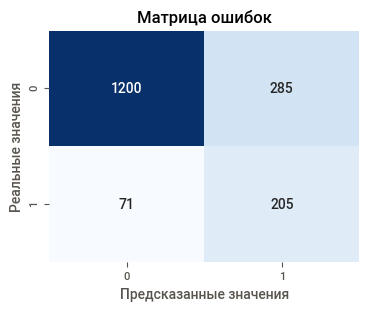

In [66]:
# Строим матрицу ошибок
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Предсказанные значения')
plt.ylabel('Реальные значения')
plt.title('Матрица ошибок')
plt.show()

True Negatives (TN) - 1200 - модель правильно предсказала, что клиенты не покинули компанию. Это хорошо, так как это верно и модель не совершила ошибку в этом случае.

True Positives (TP) - 285 - модель правильно предсказала, что клиенты покинули компанию (отток). Это также хорошо, потому что модель верно идентифицировала положительный класс (отток).

False Positives (FP) - 71 - модель неверно предсказала, что клиенты покинули компанию, хотя на самом деле они остались. Это ошибка первого рода (False Positive), и она может быть нежелательной, так как может привести к ненужным затратам на удержание клиентов, которые не собирались уходить.

False Negatives (FN) - 205 - модель неверно предсказала, что клиенты остались, хотя на самом деле они покинули компанию. Это ошибка второго рода (False Negative), и она также может быть нежелательной, так как она упускает клиентов, которые собирались уйти.

In [67]:
# Вывод наиболее важных признаков модели
importances = best_model.named_steps['classifier'].feature_importances_

features_list = list(train_features_boost.columns)

features_results = pd.DataFrame({'feature': features_list, 'importance': importances})

features_results = features_results.sort_values('importance', ascending=False).reset_index(drop=True)

features_results.head(20)

,feature,importance
0,Tenure,38.375948
1,TotalCharges,13.081509
2,MonthlyCharges,11.035472
3,Type,8.776475
4,PaymentMethod,6.198210
5,InternetService,4.101993
6,MultipleLines,3.456440
7,Partner,3.269610
8,OnlineBackup,2.472273
9,Dependents,1.914018


- Tenure (Срок пользования) имеет наибольшую важность среди всех признаков, что может говорить о том, что длительность пользования услугами компании сильно влияет на решение клиента об уходе. Возможно клиенты, которые пользуются услугами компании в течение длительного времени, могут быть более лояльными и менее склонными к оттоку.

- TotalCharges (Общие траты) и MonthlyCharges (Ежемесячные траты) также имеют значительное влияние. Это может указывать на то, что клиенты, которые тратят больше денег на услуги компании (как ежемесячно, так и в общей сложности), более вероятно останутся клиентами, чем те, кто тратит меньше.

- Type (Тип договора) и PaymentMethod (Способ оплаты) также оказывают заметное влияние на прогнозирование оттока. Это может указывать на различия в поведении и предпочтениях клиентов, заключивших разные типы договоров или использующих разные способы оплаты.

## Выводы по проекту

В этом проекте нам нужно было построить модель для прогнозирования оттока клиентов. Решалась задача бинарной классификации.

В этом проекте мы сделали такие шаги:

- Загрузили и ознакомились с данными
- Объеденили датасеты в один
- Проанализировали пропуски
- Проанализировали числове значения
- Создали синтетические признаки
- Выделили целевой признак
- Построили матрицу корреляций
- Заполнили пропуски
- Разделим датасет на обучающую и тестовую выборку
- С помощью конвейера (pipeline) закодировали категориальные признаки и стандартизировали числовые значения
- Обучили 3 модели:
    - Логистическую регрессию
    - Случайный лес
    - Градиентный бустинг
- Протестировали лучшую модель
- Проанализировали лучшую модель
    - Построили график ROC-AUC
    - Построили матрицу ошибок
    - Проанализировали наиболее важные признаки модели.

По итогу лучшее значение ROC-AUC у модели градиентного бустинга CatBoost. На тестовой выборке её метрки достигла 0.85, что удовлетворяет условию заказчика.

### Список уточняющих вопросов

Вопросов нет

## Отчёт по решению

Цель данного проекта заключалась в создании модели, способной прогнозировать отток клиентов телекоммуникационной компании. Для достижения этой цели мы провели исследовательский анализ данных, подготовили датасет для обучения моделей, обучили три различные модели машинного обучения и выбрали лучшую из них. Наша задача состояла в предотвращении ухода клиентов, чтобы снизить потери и увеличить доходы компании.


### Выполненые пункты плана

Мы успешно выполнили все ключевые шаги проекта, которые были предварительно определены в плане:

1) Исследовательский анализ данных.
2) Подготовка датасета для обучения моделей.
3) Обучение трех моделей машинного обучения.
4) Тестирование и анализ лучшей модели.
5) Написание вывода.

### Преодоление трудностей

В процессе работы мы столкнулись с несколькими трудностями и проблемами:

- Пропущенные значения после объединения таблиц. Проблема была решена после тщательного анализа данных и применения соответствующих методов.

- Недостаточное значение метрики ROC-AUC. Решить эту проблему помогло создание нового признака "срока пользования", основанного на разнице в датах начала и конца пользования услугами, позволило улучшить значение до 0.86.

- В процессе работы нам потребовалось реализовать pipeline с использованием библиотеки scikit-learn. Однако, нам встретились сложности с правильным объединением различных этапов обработки данных и обучения модели в pipeline. Нам пришлось тщательно изучить документацию и примеры кода, чтобы понять, как правильно настроить последовательность этапов и передавать параметры между ними. В результате, с преодолением этих трудностей нам удалось создать эффективный и легко масштабируемый pipeline для обработки данных и обучения модели.

### Результаты моделей

Мы обучили три модели машинного обучения и получили следующие результаты:

| Названия моделей            | Метрика ROC-AUC  |  
| --------------------------- | ---------------- | 
| Логистическая регрессия     | 0.7709         | 
| Случайный лес               | 0.8103 |  
| Градиентный бустинг CatBoost| 0.8523         | 

На основании этих результатов мы выбрали лучшую модель - градиентный бустинг в реализации CatBoost. Приведены её результаты и параметры:

- Метрика ROC-AUC на тестовой выборке - 0.8697, что говорит о высокой способности модели различать клиентов.

- Метрика Accuracy на тестовой выборке - 0.7978, что означает, что модель дает правильные ответы в 79% случаев.
    
- Сетка гиперпараметров:

    - learning_rate: [0.01, 0.001]
    
    - depth: [5, 6]
    
    - iterations: [1500, 2000]
    
- Лучшие гиперпараметры: learning_rate=0.01, depth=6, iterations=2000.


### Выбор признаков

При обучении лучшей модели мы использовали следующие признаки:

['Type', 'PaperlessBilling', 'PaymentMethod', 'Partner',           'Dependents','InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
               'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'MonthlyCharges', 'TotalCharges', 'Tenure']
    
Следующие признаки были исключены из датасета, так как они не оказывают существенного влияния на отток клиентов:

- 'customerID': уникальный идентификатор клиента не содержит информации, влияющей на отток.
- 'BeginDate': дата начала пользования услугами, исключён, что бы избежать утечки данных.
- 'gender': анализ данных показал, что пол клиента не оказывает значимого влияния на отток.

### Предобработка признаков

Для модели градиентного бустинга в реализации CatBoost категориальные признаки были просто переведены в тип 'category', так как данная модель хорошо работает с категориальными данными без необходимости кодирования. Единственное, что требовалось предобработать, это целевой признак 'EndDate', который был преобразован в бинарный признак, обозначающий уход клиента ('Yes' - ушел, 'No' - остался).
             
### Рекомендации 


Модель CatBoost показала лучшие результаты по метрикам качества и имеет хорошую интерпретируемость важности признаков. Рекомендуется использовать данную модель для прогнозирования оттока клиентов. При необходимости можно провести дополнительные исследования и анализ, чтобы улучшить модель и добиться ещё более точных прогнозов оттока. Также рекомендуеться разобраться в причинах ухода клиентов. Выяснить первопричину, а не лечить следствие, давая скидки уходящим клиентам. 